In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.kernel_ridge import KernelRidge
import json
import sklearn
import ngram
import networkx as nx
import itertools as it

In [7]:
df_egy

,id,relaxation_step_number,formation_energy_ev_natom,bandgap_energy_ev
0,1,0,0.067960,3.438673
1,2,0,0.251907,2.837926
2,2,1,0.250085,2.889246
3,2,2,0.251390,2.947492
4,2,3,0.250065,2.941308
...,...,...,...,...
29859,2400,12,0.113479,4.211003
29860,2400,13,0.113482,4.210453
29861,2400,14,0.113478,4.210785
29862,2400,15,0.113480,4.210714


In [6]:
df_latt = pd.read_csv("/home/jurka/research-project/train/relaxation/with_all_zeroes/lattice.csv")
df_frac = pd.read_csv("/home/jurka/research-project/train/relaxation/with_all_zeroes/frac.csv")
df_xyz = pd.read_csv("/home/jurka/research-project/train/relaxation/with_all_zeroes/xyz.csv")
df_egy = pd.read_csv("/home/jurka/research-project/train/relaxation/with_all_zeroes/energy.csv")
df_gen = pd.read_csv("/home/jurka/research-project/train/relaxation/general.csv")
df_force = pd.read_csv("/home/jurka/research-project/train/additional/forces.csv")

In [7]:
df_latt1 = pd.read_csv("/home/jurka/research-project/test/relaxation/with_all_zeroes/lattice.csv")
df_frac1 = pd.read_csv("/home/jurka/research-project/test/relaxation/with_all_zeroes/frac.csv")
df_xyz1 = pd.read_csv("/home/jurka/research-project/test/relaxation/with_all_zeroes/xyz.csv")
df_egy1 = pd.read_csv("/home/jurka/research-project/test/relaxation/with_all_zeroes/energy.csv")
df_gen1 = pd.read_csv("/home/jurka/research-project/test/relaxation/general.csv")
df_force1 = pd.read_csv("/home/jurka/research-project/test/additional/forces.csv")

In [8]:
ajdis = df_gen["id"].values
indexing = df_latt[["id", "relaxation_step_number"]]

In [7]:
def get_hypar(df_frac, df_latt, df_gen, ajdi, rsn):
    """Optimize hyperparametr of ngram based on spacegroup and gamma angle.
    
    Keyword arguments:
    df_frac -- fractional coordinates dataframe
    df_latt -- lattice dataframe
    df_gen -- general data dataframe
    ajdi -- id of the material
    rsn -- relaxation step number of the material
    """
    spacegroup = df_gen["spacegroup"][df_gen["id"]==ajdi].values[0]
    material = ngram.init_material(df_frac, df_latt, ajdi, rsn)
    gamma = material.lattice.gamma
    if spacegroup == 12:
        return 1.4
    elif spacegroup == 33:
        return 1.4
    elif spacegroup == 167:
        return 1.5
    elif spacegroup == 194:
        return 1.3
    elif spacegroup == 206:
        return 1.5
    elif spacegroup == 227:
        if gamma < 60:
            return 1.4
        else:
            return 1.5
    else:
        raise NameError('get_factor does not support the spacegroup: {}'.format(spacegroup))

In [ ]:
for ajdi in ajdis:
    for rsn in indexing[indexing["id"]==ajdi].relaxation_step_number.values:
        material = ngram.init_material(df_frac, df_latt, ajdi, rsn)
        mdm = material.distance_matrix
        G = ngram.gen_graph(mdm, material, "metal_oxygen_cons", hypar=get_hypar(df_frac, df_latt, df_gen, ajdi, rsn))
        coordinations = ngram.get_coordinations(G)

In [9]:
df_gen[df_gen["number_of_total_atoms"]==10]

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in
191,193,194,10,0.25,0.00,0.75
655,661,194,10,0.25,0.50,0.25
979,985,194,10,0.00,1.00,0.00
1229,1236,194,10,0.50,0.00,0.50
1612,1619,194,10,0.50,0.25,0.25
1714,1721,194,10,0.25,0.50,0.25
1744,1751,194,10,0.50,0.50,0.00
1824,1831,194,10,0.25,0.75,0.00
1977,1984,194,10,0.25,0.50,0.25
2084,2091,194,10,0.00,0.25,0.75


In [10]:
ajdi=2091
rsn=10
material = ngram.init_material(df_frac, df_latt, ajdi, rsn)
G = ngram.gen_graph(material.distance_matrix,material, "metal_oxygen_cons", hypar=get_hypar(df_frac, df_latt, df_gen, ajdi, rsn))
coordinations = ngram.get_coordinations(G)
volume = material.lattice.volume

In [10]:
def draw_g(G):
    plt.figure(figsize=(12,12)) 
    nx.draw_networkx_labels(G, pos=nx.kamada_kawai_layout(G), font_size=7, font_color="black", font_weight="bold")
    nx.draw_kamada_kawai(G, with_labels=False, node_size=450,node_color='yellow')

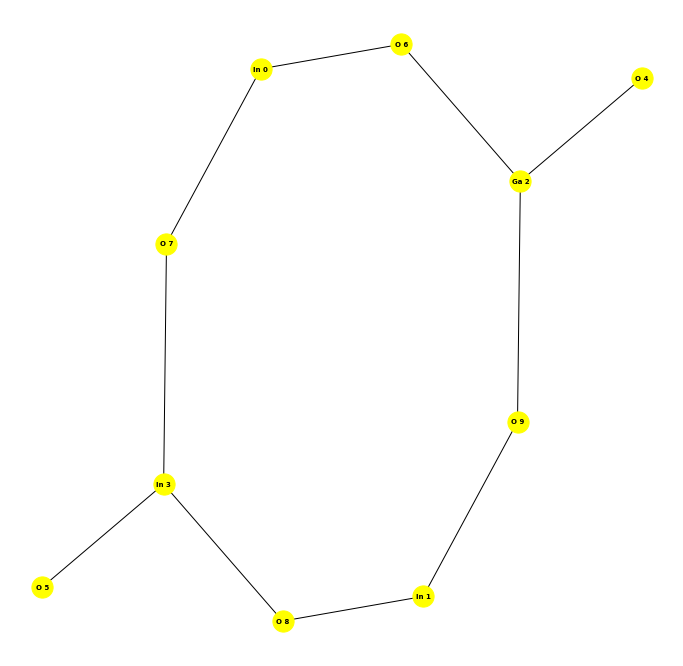

In [11]:
draw_g(G)

In [13]:
ALL_COORDINATIONS_UNIGRAM = ['Al-4', 'Al-5', 'Al-6', 'Ga-4', 'Ga-5', 'Ga-6', 'In-4', 'In-5', 'In-6', 'O-2', 'O-3', 'O-4', 'O-5']

In [14]:
# different constant for the example no. 2091
ALL_COORDINATIONS_UNIGRAM = ['Al-1', 'Al-2', 'Al-3', 'Al-4', 'Al-5', 'Al-6', 'Ga-1', 'Ga-2', 'Ga-3', 'Ga-4', 'Ga-5', 'Ga-6', 'In-1', 'In-2', 'In-3', 'In-4', 'In-5', 'In-6', 'O-1', 'O-2', 'O-3', 'O-4', 'O-5']

In [9]:
ajdi=2091
rsn=10
material = ngram.init_material(df_frac, df_latt, ajdi, rsn)
G = ngram.gen_graph(material.distance_matrix,material, "metal_oxygen_cons", hypar=ngram.get_hypar(df_frac, df_latt, df_gen, ajdi, rsn))
coordinations = ngram.get_coordinations(G)
volume = material.lattice.volume

In [15]:
hist = {}
for i in ALL_COORDINATIONS_UNIGRAM:
    hist.update({i:0})
for i in coordinations.keys():
    name = i.split()[0]
    coord = name + "-" + str(coordinations[i])
    hist.update({coord:hist[coord]+1})

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 <a list of 23 Text xticklabel objects>)

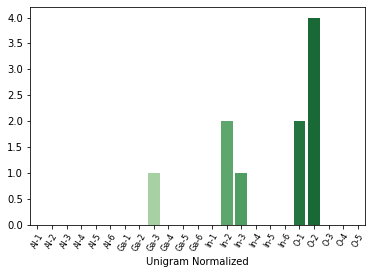

In [16]:
sns.barplot(y=[hist[i] for i in sorted(hist)], x=sorted(hist), palette="Greens") # /volume
plt.xlabel("Unigram Normalized")
plt.xticks(fontsize=8, rotation=60)
#plt.savefig("hist2.png", dpi=300)

## Moregram development and testing

In [3]:
ajdi=2091
rsn=10

In [35]:
import time
start=time.time()
coordinations = ngram.get_coordinations(G)
end=time.time()
print(end-start, "s")

0.0003361701965332031 s


In [4]:
material = ngram.init_material(df_frac, df_latt, ajdi, rsn)
G = ngram.gen_graph(material.distance_matrix,material, "metal_oxygen_cons", hypar=get_hypar(df_frac, df_latt, df_gen, ajdi, rsn))
coordinations = ngram.get_coordinations(G)
volume = material.lattice.volume

NameError: name 'ngram' is not defined

In [23]:
GA_COORDINATIONS = ['Ga-0', 'Ga-1', 'Ga-2', 'Ga-3', 'Ga-4', 'Ga-5', 'Ga-6', 'Ga-7', 'Ga-8', 'Ga-9', 'Ga-10']
AL_COORDINATIONS = ['Al-0', 'Al-1', 'Al-2', 'Al-3', 'Al-4', 'Al-5', 'Al-6', 'Al-7', 'Al-8', 'Al-9', 'Al-10']
IN_COORDINATIONS = ['In-0', 'In-1', 'In-2', 'In-3', 'In-4', 'In-5', 'In-6', 'In-7', 'In-8', 'In-9', 'In-10']
O_COORDINATIONS = ['O-0', 'O-1', 'O-2', 'O-3', 'O-4', 'O-5', 'O-6', 'O-7', 'O-8', 'O-9', 'O-10']

ALL_COORDINATIONS_UNIGRAM = AL_COORDINATIONS + GA_COORDINATIONS + IN_COORDINATIONS + O_COORDINATIONS
ALL_COORDINATIONS_BIGRAM = []
ALL_COORDINATIONS_TRIGRAM = []
ALL_COORDINATIONS_QUADGRAM = []
# general function. run only once
def gen_all_coordinations(targeted_coordination_list, parts):
    """Generate the list of all possible 
    coordination combinations for ngram of 
    given length in a easy to read format.
    Keyword arguments:
    targeted_coordination_list -- the output list
    parts -- list of all combinations "of atom-coordination"
    """
    for thing in parts:
        srted = sorted(thing)
        desc = ""
        for i in srted:
            desc += i + "/"
        desc = desc[:-1]
        targeted_coordination_list.append(desc)
        
        
# here we gooo

def gen_desc(targeted_desc_list, G, n):
    """Generate ngram descriptors.
    Keyword arguments:
    targeted_desc_list -- the output list
    G -- the graph of the material
    n -- the length of the subgraph
    """
    coordinations = ngram.get_coordinations(G)
    for i in list(it.combinations(list(G.nodes()),n)):
        H = G.subgraph(i)
        subgraph_nodes = list(H.nodes())
        subgraph_edges = list(H.edges())
        if not len(subgraph_edges) < len(subgraph_nodes)-1:
            parts = []
            for node in subgraph_nodes:
                parts.append(node.split()[0] + "-" + str(coordinations[node]))
            parts = sorted(parts)
            desc = ""
            for i in parts:
                desc += i + "/"
            desc = desc[:-1]
            targeted_desc_list.append(desc)

def gen_matrix_row(coordinations, ALL_COORDINATIONS_NGRAM):
    """Generates the matrix row for the given material
    Keyword arguments:
    coordinations -- the material coordination information
    ALL_COORDINATIONS_NGRAM -- the list of all possible ngram features
    """
    hist = {}
    for i in ALL_COORDINATIONS_NGRAM:
        hist.update({i:0})
    for coord in coordinations:
        hist.update({coord:hist[coord]+1})
    return hist            

def gen_ngram_matrix(flag, df_frac, df_latt, df_gen, n, ALL_COORDINATIONS_NGRAM):
    """Generates the ngram matrix.
    
    Keyword arguments:
    flag -- type of dataset used. options: "relaxation", "final", "vegard"
    df_frac -- dataframe of fractional coordinates
    df_latt -- dataframe of lattice vectors
    df_gen -- dataframe of general data
    n -- integer >0
    ALL_COORDINATIONS_UNIGRAM -- list of coordinations ranging from 0 to 10
    """
    if flag=="final":
        ajdis = df_gen["id"]
        try:
            indexing = df_latt[["id", "relaxation_step_number"]]
        except KeyError:
            df_latt.insert(1, "relaxation_step_number", [-1 for i in range(len(df_latt))])
            df_frac.insert(1, "relaxation_step_number", [-1 for i in range(len(df_frac))])
            indexing = df_latt[["id", "relaxation_step_number"]]
    if flag=="relaxation" or flag=="vegard":
        ajdis = df_gen["id"]
        indexing = df_latt[["id", "relaxation_step_number"]]
        
    X = []
    for ajdi in ajdis:
        for rsn in indexing[indexing["id"]==ajdi].relaxation_step_number.values:

            material = ngram.init_material(df_frac, df_latt, ajdi, rsn)
            mdm = material.distance_matrix

            G = ngram.gen_graph(mdm, material, "metal_oxygen_cons", hypar=ngram.get_hypar(df_frac, df_latt, df_gen, ajdi, rsn))
            mat_n = []
            gen_desc(mat_n, G, n)
            row = np.array(list(gen_matrix_row(mat_n, ALL_COORDINATIONS_NGRAM).values()))/material.lattice.volume
            X.append(row)
        print(ajdi, "ended.")
    
    return np.array(X)

# generating ALL_COORDINATIONS_BI TRI QUAD GRAM lists
parts = it.combinations_with_replacement(GA_COORDINATIONS + AL_COORDINATIONS + IN_COORDINATIONS + O_COORDINATIONS, 2)
gen_all_coordinations(ALL_COORDINATIONS_BIGRAM, parts)

parts = it.combinations_with_replacement(GA_COORDINATIONS + AL_COORDINATIONS + IN_COORDINATIONS + O_COORDINATIONS, 3)
gen_all_coordinations(ALL_COORDINATIONS_TRIGRAM, parts)

parts = it.combinations_with_replacement(GA_COORDINATIONS + AL_COORDINATIONS + IN_COORDINATIONS + O_COORDINATIONS, 4)
gen_all_coordinations(ALL_COORDINATIONS_QUADGRAM, parts)

In [109]:
# testing

# unigram
mat_uni = []
gen_desc(mat_uni, G, 1)

# digram
mat_bi = []
gen_desc(mat_bi, G, 2)

# trigram
mat_tri = []
gen_desc(mat_tri, G, 3)
        
# quadgram
mat_quad = []
gen_desc(mat_quad, G, 4)

print(mat_uni)
print(mat_bi)
print(mat_tri)
print(mat_quad)

gen_matrix_row(mat_uni, ALL_COORDINATIONS_UNIGRAM)
gen_matrix_row(mat_bi, ALL_COORDINATIONS_BIGRAM)
gen_matrix_row(mat_tri, ALL_COORDINATIONS_TRIGRAM)
gen_matrix_row(mat_quad, ALL_COORDINATIONS_QUADGRAM)

KeyboardInterrupt: 

In [379]:
dic = gen_matrix_row(mat_uni, ALL_COORDINATIONS_UNIGRAM)
np.array(list(dic.values()))/material.lattice.volume

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00769467,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01538933,
       0.00769467, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01538933,
       0.03077867, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [128]:
def gen_desc(targeted_desc_list, G, n):
    """Generate ngram descriptors.
    Keyword arguments:
    targeted_desc_list -- the output list
    G -- the graph of the material
    n -- the length of the subgraph
    """
    coordinations = ngram.get_coordinations(G)
    counter=0
    for i in list(it.combinations(list(G.nodes()),n)):
        H = G.subgraph(i)
        subgraph_nodes = list(H.nodes())
        subgraph_edges = list(H.edges())
        if len(subgraph_edges) == len(subgraph_nodes)-1:
            parts = sorted([node.split()[0] + "-" + str(coordinations[node]) for node in subgraph_nodes])
            desc = ""
            for i in parts:
                desc += i + "/" 
            targeted_desc_list.append(desc[:-1])

In [134]:
ajdi=3
rsn=0
coordinations=ngram.get_coordinations(G)
start=time.time()
#X = gen_ngram_matrix("relaxation", df_frac[(df_frac["id"]==ajdi) & (df_frac["relaxation_step_number"]==rsn)], df_latt[(df_latt["id"]==ajdi) & (df_latt["relaxation_step_number"]==rsn)], df_gen[(df_gen["id"]==ajdi)], 3, ALL_COORDINATIONS_TRIGRAM)

G = ngram.gen_graph(mdm, material, "metal_oxygen_cons", hypar=ngram.get_hypar(df_frac, df_latt, df_gen, ajdi, rsn))
mat_n = []
gen_desc(mat_n, G, 4)


end=time.time()
print(end-start, "s")

130.0467448234558 s


In [8]:
print(X.shape)
print(X.T[~(X.T==0).all(1)].T.shape)
X
# IT WORKS

2091 ended.
(1, 44)
(1, 5)


array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00769467,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.01538933,
        0.00769467, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.01538933,
        0.03077867, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 <a list of 44 Text xticklabel objects>)

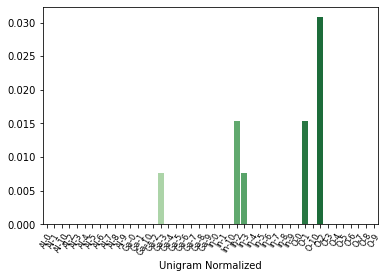

In [289]:
hist = gen_matrix_row(mat_uni, ALL_COORDINATIONS_UNIGRAM)
sns.barplot(y=[hist[i]/volume for i in sorted(hist)], x=sorted(hist), palette="Greens") # /volume
plt.xlabel("Unigram Normalized")
plt.xticks(fontsize=8, rotation=60)

In [ ]:
def matrix_decoding(vec):
    """Making a lower triangular matrix with the same value on the whole diagonal.
    Returns a numpy array.
    Keyword arguments:
    vec -- python list of numbers (output of matrix_coding)
    """
    dim = int(.5*(1 + np.sqrt(8*len(vec)-7))) # square matrix dimensions
    #print(dim)
    diag_val = vec[0]
    mat = np.diag(np.zeros(dim))
    n = 0
    for i in range(dim):
        for j in range(i):
            n += 1
            mat[i,j] = vec[n]
    return mat

In [3]:
with open('/home/jurka/Dropbox/School/Hello There/DP/Python Scripts/ngram/distance_matrices_test.json') as jsonfile:
    mat = json.load(jsonfile)

In [15]:
tridiag = matrix_decoding(mat["1"]["0"])

In [16]:
mdm = tridiag + np.transpose(tridiag)

In [180]:
df_latt_final = pd.read_csv("/home/jurka/research-project/train/final/lattice_vector.csv")
df_frac_final = pd.read_csv("/home/jurka/research-project/train/final/atoms_frac_xyz.csv")
df_xyz_final = pd.read_csv("/home/jurka/research-project/train/final/atoms_xyz.csv")
df_egy_final = pd.read_csv("/home/jurka/research-project/train/final/energy.csv")
df_gen_final = pd.read_csv("/home/jurka/research-project/train/relaxation/general.csv")

In [181]:
ALL_COORDINATIONS_UNIGRAM = [
    'Al-0',
    'Al-1',
    'Al-2',
    'Al-3',
    'Al-4', 
    'Al-5', 
    'Al-6', 
    'Al-7',
    'Al-8',
    'Al-9',
    'Al-10',
    'Ga-0',
    'Ga-1',
    'Ga-2',
    'Ga-3', 
    'Ga-4', 
    'Ga-5', 
    'Ga-6', 
    'Ga-7', 
    'Ga-8',
    'Ga-9',
    'Ga-10',
    'In-0',
    'In-1',
    'In-2',
    'In-3', 
    'In-4', 
    'In-5', 
    'In-6', 
    'In-7', 
    'In-8',
    'In-9',
    'In-10',
    'O-0',
    'O-1',
    'O-2', 
    'O-3', 
    'O-4', 
    'O-5', 
    'O-6',
    'O-7',
    'O-8',
    'O-9',
    'O-10',
    ]

ALL_COORDINATIONS_UNIGRAM_USEFUL = [ 
    'Al-4', 
    'Al-5', 
    'Al-6',  
    'Ga-4', 
    'Ga-5', 
    'Ga-6',  
    'In-4', 
    'In-5', 
    'In-6', 
    'O-2', 
    'O-3', 
    'O-4', 
    'O-5', 
    ]
def gen_unigram_matrix_old(df_frac, df_latt, df_gen, ALL_COORDINATIONS_UNIGRAM, ALL_COORDINATIONS_UNIGRAM_USEFUL):
    """Generates the unigram matrix.
    
    Keyword arguments:
    df_frac -- dataframe of fractional coordinates
    df_latt -- dataframe of lattice vectors
    df_gen -- dataframe of general data
    ALL_COORDINATIONS_UNIGRAM -- list of coordinations ranging from 0 to 10
    ALL_COORDINATIONS_UNIGRAM_USEFUL -- list of coordinations wanted in the matrix
    """
    ajdis = df_gen["id"].values
    indexing = df_latt[df_latt.columns[:2]]
    X = []
    for ajdi in ajdis:
        for rsn in indexing[indexing["id"]==ajdi].relaxation_step_number.values:

            material = ngram.init_material(df_frac, df_latt, ajdi, rsn)

            tridiag = matrix_decoding(mat[str(ajdi)][str(rsn)])
            mdm = tridiag + np.transpose(tridiag)

            G = ngram.gen_graph(mdm, material, "metal_oxygen_cons", hypar=get_hypar(df_frac, df_latt, df_gen, ajdi, rsn))
            coordinations = ngram.get_coordinations(G)

            hist = {}
            row = []
            for i in ALL_COORDINATIONS_UNIGRAM:
                hist.update({i:0})
            for i in coordinations.keys():
                name = i.split()[0]
                coord = name + "-" + str(coordinations[i])
                hist.update({coord:hist[coord]+1})
            for i in ALL_COORDINATIONS_UNIGRAM_USEFUL:
                row.append(hist[i]/material.lattice.volume)
            X.append(row)
        print(ajdi, "ended.")
    return np.array(X)
    
    
def gen_unigram_matrix(flag, df_frac, df_latt, df_gen, ALL_COORDINATIONS_UNIGRAM, ALL_COORDINATIONS_UNIGRAM_USEFUL):
    """Generates the unigram matrix.
    
    Keyword arguments:
    flag -- type of dataset used. options: "relaxation", "final", "vegard"
    mat -- loaded json object
    df_frac -- dataframe of fractional coordinates
    df_latt -- dataframe of lattice vectors
    df_gen -- dataframe of general data
    ALL_COORDINATIONS_UNIGRAM -- list of coordinations ranging from 0 to 10
    ALL_COORDINATIONS_UNIGRAM_USEFUL -- list of coordinations wanted in the matrix
    """
    if flag=="final":
        ajdis = df_gen["id"]
        try:
            indexing = df_latt[["id", "relaxation_step_number"]]
        except KeyError:
            df_latt["relaxation_step_number"] = -1
            df_frac["relaxation_step_number"] = -1
            indexing = df_latt[["id", "relaxation_step_number"]]
    if flag=="relaxation" or flag=="vegard":
        ajdis = df_gen["id"]
        indexing = df_latt[["id", "relaxation_step_number"]]
    X = []
    for ajdi in ajdis:
        for rsn in indexing[indexing["id"]==ajdi].relaxation_step_number.values:

            material = ngram.init_material(df_frac, df_latt, ajdi, rsn)
            mdm = material.distance_matrix

            #tridiag = jurka_utils.matrix_decoding(mat[str(ajdi)][str(rsn)])
            #mdm = tridiag + np.transpose(tridiag)

            G = ngram.gen_graph(mdm, material, "metal_oxygen_cons", hypar=ngram.get_hypar(df_frac, df_latt, df_gen, ajdi, rsn))
            coordinations = ngram.get_coordinations(G)
            print(ajdi, rsn)
            hist = {}
            row = []
            for i in ALL_COORDINATIONS_UNIGRAM:
                hist.update({i:0})
            for i in coordinations.keys():
                name = i.split()[0]
                coord = name + "-" + str(coordinations[i])
                hist.update({coord:hist[coord]+1})
            for i in ALL_COORDINATIONS_UNIGRAM_USEFUL:
                row.append(hist[i]/material.lattice.volume)
            X.append(row)
        print(ajdi, "ended.")
    return np.array(X)

In [189]:
gen_unigram_matrix("final", df_frac_final[:80], df_latt_final[:1], df_gen_final[:1], ALL_COORDINATIONS_UNIGRAM, ALL_COORDINATIONS_UNIGRAM_USEFUL)

1 -1
1 ended.


array([[0.00639229, 0.        , 0.01917686, 0.00383537, 0.        ,
        0.01150612, 0.        , 0.        , 0.        , 0.        ,
        0.03068298, 0.02045532, 0.01022766]])

In [190]:
gen_unigram_matrix("final", df_frac[:80], df_latt[:1], df_gen[:1], ALL_COORDINATIONS_UNIGRAM, ALL_COORDINATIONS_UNIGRAM_USEFUL)

1 0
1 ended.


array([[0.00639229, 0.        , 0.01917686, 0.00383537, 0.        ,
        0.01150612, 0.        , 0.        , 0.        , 0.        ,
        0.03068298, 0.02045532, 0.01022766]])

In [184]:
df_latt_final[:1]

,id,lattice_vector_1_x,lattice_vector_1_y,lattice_vector_1_z,lattice_vector_2_x,lattice_vector_2_y,lattice_vector_2_z,lattice_vector_3_x,lattice_vector_3_y,lattice_vector_3_z
0,1,9.948758,-0.023988,-0.012877,0.020066,8.567744,-0.038975,0.014275,-0.000454,9.176459


In [188]:
df_frac_final.insert(1, "relaxation_step_number", [-1 for i in range(len(df_frac_final))],True)
df_latt_final

,id,relaxation_step_number,lattice_vector_1_x,lattice_vector_1_y,lattice_vector_1_z,lattice_vector_2_x,lattice_vector_2_y,lattice_vector_2_z,lattice_vector_3_x,lattice_vector_3_y,lattice_vector_3_z
0,1,-1,9.948758,-0.023988,-0.012877,0.020066,8.567744,-0.038975,0.014275,-0.000454,9.176459
1,2,-1,6.199465,0.016923,-0.012412,-3.115498,5.364225,0.017218,0.047827,-0.047253,23.606042
2,3,-1,9.849462,-0.013572,-0.147161,4.932621,2.837125,-0.073890,-0.310164,-0.040082,13.959430
3,4,-1,5.007465,-0.004368,0.005070,-2.500028,4.338985,-0.003880,-0.016903,0.005237,13.564430
4,5,-1,6.644448,0.005182,0.000202,-3.323296,5.753607,0.001899,-0.000589,-0.008493,24.276048
...,...,...,...,...,...,...,...,...,...,...,...
2386,2396,-1,4.928115,-0.008517,-0.029318,0.001165,8.490894,-0.007589,-0.001523,-0.016793,9.136523
2387,2397,-1,4.956242,0.023875,-0.002402,-2.498600,4.279960,-0.001656,0.005975,0.009243,13.431205
2388,2398,-1,9.225599,-0.008624,-0.006999,-0.006928,9.225574,-0.008691,-0.008635,-0.006940,9.225602
2389,2399,-1,10.726156,0.135666,-0.152791,0.076012,9.157343,-0.085433,-0.015826,0.096708,9.572697


In [185]:
df_latt_final.insert(1, "relaxation_step_number", [-1 for i in range(len(df_latt_final))],True)
df_latt_final

,id,relaxation_step_number,lattice_vector_1_x,lattice_vector_1_y,lattice_vector_1_z,lattice_vector_2_x,lattice_vector_2_y,lattice_vector_2_z,lattice_vector_3_x,lattice_vector_3_y,lattice_vector_3_z
0,1,-1,9.948758,-0.023988,-0.012877,0.020066,8.567744,-0.038975,0.014275,-0.000454,9.176459
1,2,-1,6.199465,0.016923,-0.012412,-3.115498,5.364225,0.017218,0.047827,-0.047253,23.606042
2,3,-1,9.849462,-0.013572,-0.147161,4.932621,2.837125,-0.073890,-0.310164,-0.040082,13.959430
3,4,-1,5.007465,-0.004368,0.005070,-2.500028,4.338985,-0.003880,-0.016903,0.005237,13.564430
4,5,-1,6.644448,0.005182,0.000202,-3.323296,5.753607,0.001899,-0.000589,-0.008493,24.276048
...,...,...,...,...,...,...,...,...,...,...,...
2386,2396,-1,4.928115,-0.008517,-0.029318,0.001165,8.490894,-0.007589,-0.001523,-0.016793,9.136523
2387,2397,-1,4.956242,0.023875,-0.002402,-2.498600,4.279960,-0.001656,0.005975,0.009243,13.431205
2388,2398,-1,9.225599,-0.008624,-0.006999,-0.006928,9.225574,-0.008691,-0.008635,-0.006940,9.225602
2389,2399,-1,10.726156,0.135666,-0.152791,0.076012,9.157343,-0.085433,-0.015826,0.096708,9.572697


In [134]:
k=0
(df_frac[df_frac["id"]==1][["L1","L2","L3"]][k:] == df_frac_final[df_frac_final["id"]==1][["L1","L2","L3"]][k:]).all()

L1    False
L2     True
L3     True
dtype: bool

In [107]:
np.savetxt("unigram_matrix_test.csv", X, delimiter=",")

In [14]:
sklearn.metrics.pairwise.PAIRWISE_KERNEL_FUNCTIONS

{'additive_chi2': <function sklearn.metrics.pairwise.additive_chi2_kernel(X, Y=None)>,
 'chi2': <function sklearn.metrics.pairwise.chi2_kernel(X, Y=None, gamma=1.0)>,
 'linear': <function sklearn.metrics.pairwise.linear_kernel(X, Y=None, dense_output=True)>,
 'polynomial': <function sklearn.metrics.pairwise.polynomial_kernel(X, Y=None, degree=3, gamma=None, coef0=1)>,
 'poly': <function sklearn.metrics.pairwise.polynomial_kernel(X, Y=None, degree=3, gamma=None, coef0=1)>,
 'rbf': <function sklearn.metrics.pairwise.rbf_kernel(X, Y=None, gamma=None)>,
 'laplacian': <function sklearn.metrics.pairwise.laplacian_kernel(X, Y=None, gamma=None)>,
 'sigmoid': <function sklearn.metrics.pairwise.sigmoid_kernel(X, Y=None, gamma=None, coef0=1)>,
 'cosine': <function sklearn.metrics.pairwise.cosine_similarity(X, Y=None, dense_output=True)>}

In [7]:
krr = KernelRidge(alpha=1.0, kernel="rbf", gamma=1.0)

In [8]:
krr.get_params()

{'alpha': 1.0,
 'coef0': 1,
 'degree': 3,
 'gamma': 1.0,
 'kernel': 'rbf',
 'kernel_params': None}

In [ ]:
krr.fit(X,y)